### Download Data

In [ ]:
# adapted from: https://github.com/ndrplz/ConvLSTM_pytorch

In [1]:
#  Download the toy moving mnist dataset for testing
# ! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy

### Import Dependencies

In [55]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt
from ConvLSTM import ConvLSTM
from tqdm.notebook import tqdm

# Control whether we want to compute the loss function based on 
# the entire predicted sequence (original sequence shifted by one)
# or compute the loss function based on the last predicted frame only
entire_sequence_version=False

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import Data and Create Dataloaders

In [4]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate3d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # the output is the input sequence shift right by 1, both have length 19
    rand = np.random.randint(10,20)
    seq_len=batch.shape[2]
    return batch[:,:,0:seq_len-1], batch[:,:,1:seq_len]      

def collate2d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]

if entire_sequence_version:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)
else:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

### Visualize Data

In [5]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

In [153]:
input.shape

torch.Size([3, 1, 10, 64, 64])

### Instantiate Model, Optimizer and Loss

In [6]:
# The input video frames are grayscale, thus single channel
if entire_sequence_version:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=True).to(device)
else:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=False).to(device)
    

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

### Train for about 20 epochs

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(tqdm(train_loader)):
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))

In [149]:
#torch.save(model.state_dict(), "mnist_temp")

### Visualize what our model has learned so far

In [145]:
### for 3d evaluation only 
if entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).detach().cpu().numpy()[:,9])*255.0

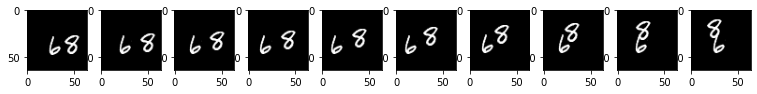

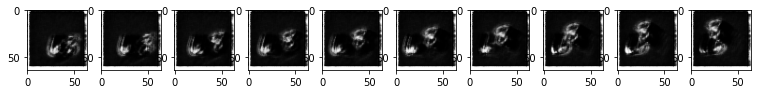

In [146]:
### for 3D evaluation only
if entire_sequence_version:
    seq_len=input.squeeze(1)[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(input.squeeze(1)[0][i].cpu().numpy() * 255, cmap='gray', vmin=0, vmax=255)

    seq_len=output[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(output[0][i], cmap='gray', vmin=0, vmax=255)

In [147]:
### for 2d evaluation
if not entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [148]:
for tgt, out in zip(target, output):       # Loop over samples

    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))